# Iteration 23: Multiple Replications (2)

## Plain English Summary

The second step of implementing multiple replications writes new code only:

1. Create a multiple replications function that calls `single_run` and stores run results.
2. Create three functions for combining replications and calculating the mean of the occupancy and prob of delay distributions
3. Create a function that produces a table summary of "probability of delay" and "1 in every n patients delayed" (to match paper).

These are standard python functions that are relatively simple we therefore included all of functions in the same prompt.

> The tester writes the script to run all of these functions.
> 
> To simplify the notebook we remove the scripts to run ASU and Rehab models individually using scripts. Models are still tested individually in the formal testing section.

## Notebook imports

In [1]:
from IPython.display import Markdown, display, HTML
import math
import statistics
from sim_tools.distributions import Lognormal
import numpy as np
import pandas as pd

## LLM Prompt 1 <a class="anchor" id="llm_prompt"></a>

In [2]:
display(Markdown("inputs/23_iteration.md"))

create a function called `multiple_replications`. The function accepts an instance of `Experiment` and the number of replications (default=5) as parameters. The functions logic of each replication is as follows:

1. call `single_run` 
2. store the returned results of the replication for later use in a list called `rep_results`

after all replications are complete return `rep_results`


create a function called `combine_pdelay_results(rep_results)` where `rep_results` is a python list where each item is a dictionary.  The function logic is as follows:

Loop through `rep_results`:

1. select `prob_delay_asu` and `unique_vals_asu`.
2. find the minimum value in `unique_vals_asu` called `min_occupancy_asu`
3. Create an new array of length 30 of all zeros.  Copy values from `prob_delay_asu` to the new array using `unique_vals_asu` as the index.
4. In the new array set all values whose array index is < `min_occupancy` to 1.0
5. store the results a new result list

Repeat for `prob_delay_rehab`, `unique_vals_rehab` and `min_occupancy_rehab`
Return the result lists in a tuple of numpy arrays


create a function called `combine_occup_results(rep_results)` where `rep_results` is a python list where each item is a dictionary.  The function logic is as follows:

Loop through `rep_results`:

1. select `relative_freq_asu` and `unique_vals_asu`.
2. Create an new array of length 30 of all zeros.  Copy values from `relative_freq_asu` to the new array using `unique_vals_asu` as the index.
3. store the results a new result list

Repeat for `relative_freq_rehab`,
Return the result lists in a tuple of numpy arrays



create a function called `mean_results(rep_results)` where `rep_results` is a numpy array. The function should return the mean of the columns in rep_results.


create a function called `summary_table(mean_pdelay, min_beds, max_beds, bed_type)`. 
1. Slice `mean_pdelay` between `min_beds` and `max_beds`.
2. Creates a pandas dataframe. The first column is the slice of `mean_pdelay` (2dp) the second column is 1 / the slice of `mean_pdelay` (to 2dp).  Round the 2nd column down to nearest integer.
3. The column names are "p(delay)" and "1 in every n patients delayed".
4. The index should start at min_beds and end at max_beds.  Its name is "No. " + `bed_type` + " beds"
5.  Return the dataframe


## Diff of notebooks. <a class="anchor" id="diff"></a>

In [3]:
display(HTML("diffs/23_iteration.html"))

## Date and time of input to LLM

> 1300 23rd March 2024

## Observations on the LLM Output

* This iteration generated all new functions. These are all listed below.


## Sources reported by the LLM

* None reported at time of generation.

## Code carried over 

* `normal_moments_from_lognormal` - a function for converting moments of a lognormal to underlying normal
*  `audit_acute_occupancy` - code to observe the ASU occupancy at specified time intervals.
*  `calculate_occupancy_frequencies` - calculate relative frequencies of occupancy observations
*  `occupancy_plot` - show occupancy as a bar chart.
*  `calculate_prob_delay`
*  `prob_delay_plot`
*  `Experiment`
*  `RehabilitationUnit`
*  `AcuteStrokeUnit`
*  `single_run` - code that runs the full model ASU+REHAB

## Model code <a class="anchor" id="model_code"></a>

### Imports

In [4]:
import simpy
import numpy as np
import matplotlib.pyplot as plt

### lognormal function

In [5]:
# External function to convert Lognormal moments to Normal moments
def normal_moments_from_lognormal(mean, std_dev):
    phi = np.sqrt(std_dev ** 2 + mean ** 2)
    mu = np.log(mean ** 2 / np.sqrt(std_dev ** 2 + mean ** 2))
    sigma = np.sqrt(np.log(phi ** 2 / mean ** 2))
    return mu, sigma

### Experiment class

In [6]:
class Experiment:
    def __init__(self, stroke_mean=1.2, tia_mean=9.3, neuro_mean=3.6, other_mean=3.2,
                 rehab_mean=7.4, rehab_std_dev=8.6, esd_mean=4.6, esd_std_dev=4.8,
                 other_dest_mean=7.0, other_dest_std_dev=8.7,
                 tia_dest_mean=1.8, tia_dest_std_dev=5.0,
                 neuro_dest_mean=4.0, neuro_dest_std_dev=5.0,
                 other_dest_mean_2=3.8, other_dest_std_dev_2=5.2,
                 results_collection_period=1825, trace=False,
                 rehab_stroke_iat=21.8, rehab_neuro_iat=31.7, rehab_other_iat=28.6,
                 rehab_stroke_esd_mean=30.3, rehab_stroke_esd_std_dev=23.1,
                 rehab_stroke_other_mean=28.4, rehab_stroke_other_std_dev=27.2,
                 rehab_neuro_mean=27.6, rehab_neuro_std_dev=28.4,
                 rehab_other_mean=16.1, rehab_other_std_dev=14.1,
                 rehab_stroke_post_destination_prob=[0.4, 0.6],
                 rehab_neuro_post_destination_prob=[0.09, 0.91],
                 rehab_other_post_destination_prob=[0.12, 0.88],
                 warm_up=1095):
        
        self.stroke_interarrival_mean = stroke_mean
        self.tia_interarrival_mean = tia_mean
        self.neuro_interarrival_mean = neuro_mean
        self.other_interarrival_mean = other_mean
        self.rehab_mean = rehab_mean
        self.rehab_std_dev = rehab_std_dev
        self.esd_mean = esd_mean
        self.esd_std_dev = esd_std_dev
        self.other_dest_mean = other_dest_mean
        self.other_dest_std_dev = other_dest_std_dev
        self.tia_dest_mean = tia_dest_mean
        self.tia_dest_std_dev = tia_dest_std_dev
        self.neuro_dest_mean = neuro_dest_mean
        self.neuro_dest_std_dev = neuro_dest_std_dev
        self.other_dest_mean_2 = other_dest_mean_2
        self.other_dest_std_dev_2 = other_dest_std_dev_2
        self.results_collection_period = results_collection_period
        self.warm_up = warm_up  # New member variable for warm-up period
        self.trace = trace
        self.asu_occupancy = []  # List to store ASU occupancy data
        self.rehab_occupancy = []  # List to store Rehabilitation Unit occupancy data

        
        # New parameters for RehabilitationUnit treatment distributions and probabilities
        self.rehab_stroke_iat = rehab_stroke_iat
        self.rehab_neuro_iat = rehab_neuro_iat
        self.rehab_other_iat = rehab_other_iat
        
        self.rehab_stroke_esd_mean = rehab_stroke_esd_mean
        self.rehab_stroke_esd_std_dev = rehab_stroke_esd_std_dev
        
        self.rehab_stroke_other_mean = rehab_stroke_other_mean
        self.rehab_stroke_other_std_dev = rehab_stroke_other_std_dev
        
        self.rehab_neuro_mean = rehab_neuro_mean
        self.rehab_neuro_std_dev = rehab_neuro_std_dev
        
        self.rehab_other_mean = rehab_other_mean
        self.rehab_other_std_dev = rehab_other_std_dev
        
        # Probabilities for post-rehab destination sampling for each patient type in RehabilitationUnit
        self.rehab_stroke_post_destination_prob = rehab_stroke_post_destination_prob
        self.rehab_neuro_post_destination_prob = rehab_neuro_post_destination_prob
        self.rehab_other_post_destination_prob = rehab_other_post_destination_prob

    def reset_kpi(self):
        """Reset the occupancy lists to empty."""
        self.asu_occupancy.clear()
        self.rehab_occupancy.clear()

### Acute stroke unit class

In [7]:
class AcuteStrokeUnit:
    def __init__(self, env, experiment, rehab_unit):
        self.env = env
        self.experiment = experiment
        self.rehab_unit = rehab_unit
        self.patient_count = 0
        self.occupancy = 0

    def stroke_acute_treatment(self, post_asu_destination):
        if post_asu_destination == "Rehab":
            mu, sigma = normal_moments_from_lognormal(self.experiment.rehab_mean, self.experiment.rehab_std_dev)
            length_of_stay = np.random.lognormal(mean=mu, sigma=sigma)
        elif post_asu_destination == "ESD":
            mu, sigma = normal_moments_from_lognormal(self.experiment.esd_mean, self.experiment.esd_std_dev)
            length_of_stay = np.random.lognormal(mean=mu, sigma=sigma)
        else:
            mu, sigma = normal_moments_from_lognormal(self.experiment.other_dest_mean, self.experiment.other_dest_std_dev)
            length_of_stay = np.random.lognormal(mean=mu, sigma=sigma)
        
        self.occupancy += 1  # Increment occupancy when a patient arrives
        yield self.env.timeout(length_of_stay)
        if self.experiment.trace:
            print(f"Stroke patient {self.patient_count} finished treatment at {self.env.now} days")
        self.occupancy -= 1  # Decrement occupancy at the end of treatment
        if post_asu_destination == "Rehab":
            self.rehab_unit.occupancy += 1
            self.env.process(self.rehab_unit.stroke_rehab_treatment())

    def tia_acute_treatment(self, post_asu_destination):
        mu, sigma = normal_moments_from_lognormal(self.experiment.tia_dest_mean, self.experiment.tia_dest_std_dev)
        length_of_stay = np.random.lognormal(mean=mu, sigma=sigma)
        
        self.occupancy += 1  # Increment occupancy when a patient arrives
        yield self.env.timeout(length_of_stay)
        if self.experiment.trace:
            print(f"TIA patient {self.patient_count} finished treatment at {self.env.now} days")
        self.occupancy -= 1  # Decrement occupancy at the end of treatment
        if post_asu_destination == "Rehab":
            self.rehab_unit.occupancy += 1
            self.env.process(self.rehab_unit.tia_rehab_treatment())

    def neuro_acute_treatment(self, post_asu_destination):
        mu, sigma = normal_moments_from_lognormal(self.experiment.neuro_dest_mean, self.experiment.neuro_dest_std_dev)
        length_of_stay = np.random.lognormal(mean=mu, sigma=sigma)
        
        self.occupancy += 1  # Increment occupancy when a patient arrives
        yield self.env.timeout(length_of_stay)
        if self.experiment.trace:
            print(f"Complex Neuro patient {self.patient_count} finished treatment at {self.env.now} days")
        self.occupancy -= 1  # Decrement occupancy at the end of treatment
        if post_asu_destination == "Rehab":
            self.rehab_unit.occupancy += 1
            self.env.process(self.rehab_unit.neuro_rehab_treatment())

    def other_acute_treatment(self, post_asu_destination):
        mu, sigma = normal_moments_from_lognormal(self.experiment.other_dest_mean_2, self.experiment.other_dest_std_dev_2)
        length_of_stay = np.random.lognormal(mean=mu, sigma=sigma)
        
        self.occupancy += 1  # Increment occupancy when a patient arrives
        yield self.env.timeout(length_of_stay)
        if self.experiment.trace:
            print(f"Other patient {self.patient_count} finished treatment at {self.env.now} days")
        self.occupancy -= 1  # Decrement occupancy at the end of treatment
        if post_asu_destination == "Rehab":
            self.rehab_unit.occupancy += 1
            self.env.process(self.rehab_unit.other_rehab_treatment())

    def stroke_patient_generator(self):
        while True:
            interarrival_time = np.random.exponential(self.experiment.stroke_interarrival_mean)
            yield self.env.timeout(interarrival_time)
            self.patient_count += 1
            post_asu_destination = np.random.choice(["Rehab", "ESD", "Other"], p=[0.24, 0.13, 0.63])
            if self.experiment.trace:
                print(f"Stroke patient {self.patient_count} arrived at {self.env.now} days and will go to {post_asu_destination}")
            self.env.process(self.stroke_acute_treatment(post_asu_destination))

    def tia_patient_generator(self):
        while True:
            interarrival_time = np.random.exponential(self.experiment.tia_interarrival_mean)
            yield self.env.timeout(interarrival_time)
            self.patient_count += 1
            post_asu_destination = np.random.choice(["Rehab", "ESD", "Other"], p=[0.01, 0.01, 0.98])
            if self.experiment.trace:
                print(f"TIA patient {self.patient_count} arrived at {self.env.now} days and will go to {post_asu_destination}")
            self.env.process(self.tia_acute_treatment(post_asu_destination))

    def neuro_patient_generator(self):
        while True:
            interarrival_time = np.random.exponential(self.experiment.neuro_interarrival_mean)
            yield self.env.timeout(interarrival_time)
            self.patient_count += 1
            post_asu_destination = np.random.choice(["Rehab", "ESD", "Other"], p=[0.11, 0.05, 0.84])
            if self.experiment.trace:
                print(f"Complex Neuro patient {self.patient_count} arrived at {self.env.now} days and will go to {post_asu_destination}")
            self.env.process(self.neuro_acute_treatment(post_asu_destination))

    def other_patient_generator(self):
        while True:
            interarrival_time = np.random.exponential(self.experiment.other_interarrival_mean)
            yield self.env.timeout(interarrival_time)
            self.patient_count += 1
            post_asu_destination = np.random.choice(["Rehab", "ESD", "Other"], p=[0.05, 0.10, 0.85])
            if self.experiment.trace:
                print(f"Other patient {self.patient_count} arrived at {self.env.now} days and will go to {post_asu_destination}")
            self.env.process(self.other_acute_treatment(post_asu_destination))

### Rehabilitation Unit class <a class="anchor" id="iteration_code_a"></a>

In [8]:
class RehabilitationUnit:
    def __init__(self, env, experiment):
        self.env = env
        self.experiment = experiment
        self.patient_count = 0
        self.stroke_count = 0
        self.neuro_count = 0
        self.other_count = 0
        self.occupancy = 0

    def stroke_patient_generator(self):
        while True:
            interarrival_time = np.random.exponential(self.experiment.rehab_stroke_iat)
            yield self.env.timeout(interarrival_time)
            self.patient_count += 1
            self.stroke_count += 1
            if self.experiment.trace:
                print(f"Stroke patient {self.patient_count} arrived at Rehabilitation Unit at {self.env.now} days")
            self.occupancy += 1
            self.env.process(self.stroke_rehab_treatment())

    def neuro_patient_generator(self):
        while True:
            interarrival_time = np.random.exponential(self.experiment.rehab_neuro_iat)
            yield self.env.timeout(interarrival_time)
            self.patient_count += 1
            self.neuro_count += 1
            if self.experiment.trace:
                print(f"Complex Neurological patient {self.patient_count} arrived at Rehabilitation Unit at {self.env.now} days")
            self.occupancy += 1
            self.env.process(self.neuro_rehab_treatment())

    def other_patient_generator(self):
        while True:
            interarrival_time = np.random.exponential(self.experiment.rehab_other_iat)
            yield self.env.timeout(interarrival_time)
            self.patient_count += 1
            self.other_count += 1
            if self.experiment.trace:
                print(f"Other patient {self.patient_count} arrived at Rehabilitation Unit at {self.env.now} days")
            self.occupancy += 1
            self.env.process(self.other_rehab_treatment())

    def tia_rehab_treatment(self):
        post_rehab_destination = np.random.choice([0, 100])
        mu, sigma = normal_moments_from_lognormal(18.7, 23.5)
        
        length_of_stay = np.random.lognormal(mean=mu, sigma=sigma)
        
        yield self.env.timeout(length_of_stay)
        
        if self.experiment.trace:
            print(f"TIA patient {self.patient_count} finished treatment at Rehabilitation Unit at {self.env.now} days")
        
        self.occupancy -= 1

    def stroke_rehab_treatment(self):
        post_rehab_destination = np.random.choice(["ESD", "Other"], p=self.experiment.rehab_stroke_post_destination_prob)
        if post_rehab_destination == "ESD":
            mu, sigma = normal_moments_from_lognormal(self.experiment.rehab_stroke_esd_mean, self.experiment.rehab_stroke_esd_std_dev)
        else:
            mu, sigma = normal_moments_from_lognormal(self.experiment.rehab_stroke_other_mean, self.experiment.rehab_stroke_other_std_dev)
        
        length_of_stay = np.random.lognormal(mean=mu, sigma=sigma)
        
        yield self.env.timeout(length_of_stay)
        
        if self.experiment.trace:
            print(f"Stroke patient {self.patient_count} finished treatment at Rehabilitation Unit at {self.env.now} days")
        
        self.occupancy -= 1

    def neuro_rehab_treatment(self):
        post_rehab_destination = np.random.choice(["ESD", "Other"], p=self.experiment.rehab_neuro_post_destination_prob)
        mu, sigma = normal_moments_from_lognormal(self.experiment.rehab_neuro_mean, self.experiment.rehab_neuro_std_dev)
        
        length_of_stay = np.random.lognormal(mean=mu, sigma=sigma)
        
        yield self.env.timeout(length_of_stay)
        
        if self.experiment.trace:
            print(f"Complex Neurological patient {self.patient_count} finished treatment at Rehabilitation Unit at {self.env.now} days")
        
        self.occupancy -= 1

    def other_rehab_treatment(self):
        post_rehab_destination = np.random.choice(["ESD", "Other"], p=self.experiment.rehab_other_post_destination_prob)
        mu, sigma = normal_moments_from_lognormal(self.experiment.rehab_other_mean, self.experiment.rehab_other_std_dev)
        
        length_of_stay = np.random.lognormal(mean=mu, sigma=sigma)
        
        yield self.env.timeout(length_of_stay)
        
        if self.experiment.trace:
            print(f"Other patient {self.patient_count} finished treatment at Rehabilitation Unit at {self.env.now} days")
        
        self.occupancy -= 1

### Occupancy auditing function

In [9]:
def audit_acute_occupancy(env, first_interval, audit_interval, asu, experiment):
    yield env.timeout(first_interval)
    while True:
        experiment.asu_occupancy.append(asu.occupancy)
        yield env.timeout(audit_interval)

In [10]:
def audit_rehab_occupancy(env, first_interval, audit_interval, rehab_unit, experiment):
    yield env.timeout(first_interval)
    while True:
        experiment.rehab_occupancy.append(rehab_unit.occupancy)
        yield env.timeout(audit_interval)

### Occupancy post-processing code

In [11]:
def calculate_occupancy_frequencies(data):
    unique_values, counts = np.unique(data, return_counts=True)
    relative_frequency = counts / len(data)
    cumulative_frequency = np.cumsum(relative_frequency)
    return relative_frequency, cumulative_frequency, unique_values

In [12]:
def occupancy_plot(relative_frequency, unique_values, x_label="No. people in ASU", fig_size=(12, 5)):
    fig, ax = plt.subplots(figsize=fig_size)
    ax.bar(unique_values, relative_frequency, align='center', alpha=0.7)
    ax.set_xticks(np.arange(0, 31, 1))
    ax.set_xlabel(x_label)
    ax.set_ylabel('Relative Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.title('Occupancy Relative Frequency Distribution')
    plt.show()
    return fig, ax

### Probability of deplay post-processing code

In [13]:
def calculate_prob_delay(relative_frequencies, cumulative_frequencies):
    prob_delay = np.array(relative_frequencies) / np.array(cumulative_frequencies)
    return prob_delay

In [14]:
def prob_delay_plot(prob_delay, unique_values, x_label="No. acute beds available", fig_size=(12, 5)):
    fig, ax = plt.subplots(figsize=fig_size)
    ax.step(unique_values, prob_delay, where='post')
    ax.set_xticks(np.arange(0, 31, 1))
    ax.set_xlabel(x_label)
    ax.set_ylabel('Probability of Delay')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.title('Probability of Delay Distribution')
    plt.show()
    return fig, ax

## Function to perform a single run of ASU+REHAB

In [15]:
def single_run(experiment):
    experiment.reset_kpi()
    
    env = simpy.Environment()
    
    # Create an instance of RehabilitationUnit and AcuteStrokeUnit with the Experiment parameters
    rehab_unit = RehabilitationUnit(env, experiment)
    acu_experiment = AcuteStrokeUnit(env, experiment, rehab_unit)
    
    # Initialize patient generators as simpy processes in both units
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())
    
    env.process(rehab_unit.stroke_patient_generator())
    env.process(rehab_unit.neuro_patient_generator())
    env.process(rehab_unit.other_patient_generator())
    
    # Initialize audit functions for both units to record occupancy at intervals
    env.process(audit_rehab_occupancy(env, experiment.warm_up, 1, rehab_unit, experiment))
    env.process(audit_acute_occupancy(env, experiment.warm_up, 1, acu_experiment, experiment))
    
    # Run the simulation for the specified period (results_collection_period + warm_up)
    env.run(until=experiment.results_collection_period + experiment.warm_up)
    
    # Calculate occupancy frequencies and probability of delay for both units and return the results in a dictionary
    relative_freq_asu, cumulative_freq_asu, unique_vals_asu = calculate_occupancy_frequencies(experiment.asu_occupancy)
    relative_freq_rehab, cumulative_freq_rehab, unique_vals_rehab = calculate_occupancy_frequencies(experiment.rehab_occupancy)
    
    prob_delay_asu = calculate_prob_delay(relative_freq_asu, cumulative_freq_asu)
    prob_delay_rehab = calculate_prob_delay(relative_freq_rehab, cumulative_freq_rehab)
    
    return {
            'relative_freq_asu': relative_freq_asu,
            'prob_delay_asu': prob_delay_asu,
            'unique_vals_asu': unique_vals_asu,
            'relative_freq_rehab': relative_freq_rehab,
            'prob_delay_rehab': prob_delay_rehab,
            'unique_vals_rehab': unique_vals_rehab 
           }

### Multiple Replication function

In [16]:
def multiple_replications(experiment_instance, num_replications=5):
    rep_results = []
    for _ in range(num_replications):
        rep_results.append(single_run(experiment_instance))
    return rep_results

### Functions to combine replication results

In [17]:
def combine_pdelay_results(rep_results):
    result_list_asu = []
    result_list_rehab = []
    
    for rep_result in rep_results:
        prob_delay_asu = rep_result['prob_delay_asu']
        unique_vals_asu = rep_result['unique_vals_asu']
        
        min_occupancy_asu = min(unique_vals_asu)
        
        new_array_asu = np.zeros(30)
        for i, val in zip(unique_vals_asu, prob_delay_asu):
            new_array_asu[i] = val
        
        new_array_asu[:min_occupancy_asu] = 1.0
        
        result_list_asu.append(new_array_asu)
        
        prob_delay_rehab = rep_result['prob_delay_rehab']
        unique_vals_rehab = rep_result['unique_vals_rehab']
        
        min_occupancy_rehab = min(unique_vals_rehab)
        
        new_array_rehab = np.zeros(30)
        for i, val in zip(unique_vals_rehab, prob_delay_rehab):
            new_array_rehab[i] = val
        
        new_array_rehab[:min_occupancy_rehab] = 1.0
        
        result_list_rehab.append(new_array_rehab)
    
    return np.array(result_list_asu), np.array(result_list_rehab)

In [18]:
def combine_occup_results(rep_results):
    result_list_asu = []
    result_list_rehab = []
    
    for rep_result in rep_results:
        relative_freq_asu = rep_result['relative_freq_asu']
        unique_vals_asu = rep_result['unique_vals_asu']
        
        new_array_asu = np.zeros(30)
        for i, val in zip(unique_vals_asu, relative_freq_asu):
            new_array_asu[i] = val
        
        result_list_asu.append(new_array_asu)
        
        relative_freq_rehab = rep_result['relative_freq_rehab']
        unique_vals_rehab = rep_result['unique_vals_rehab']
        
        new_array_rehab = np.zeros(30)
        for i, val in zip(unique_vals_rehab, relative_freq_rehab):
            new_array_rehab[i] = val
        
        result_list_rehab.append(new_array_rehab)
    
    return np.array(result_list_asu), np.array(result_list_rehab)

In [19]:
def mean_results(rep_results):
    return np.mean(rep_results, axis=0)

### Tabular results for p(delay)

In [20]:
def summary_table(mean_pdelay, min_beds, max_beds, bed_type):
    sliced_mean_pdelay = mean_pdelay[min_beds:max_beds+1]
    inv_mean_pdelay = 1 / sliced_mean_pdelay
    inv_mean_pdelay_rounded = np.floor(inv_mean_pdelay).astype(int)
    
    df_summary_table = pd.DataFrame({
        'p(delay)': sliced_mean_pdelay.round(2),
        '1 in every n patients delayed': inv_mean_pdelay_rounded
    }, index=pd.Index(range(min_beds, max_beds+1), name="No. " + bed_type + " beds"))
    
    return df_summary_table

> The script below was created by the Tester iteration 23

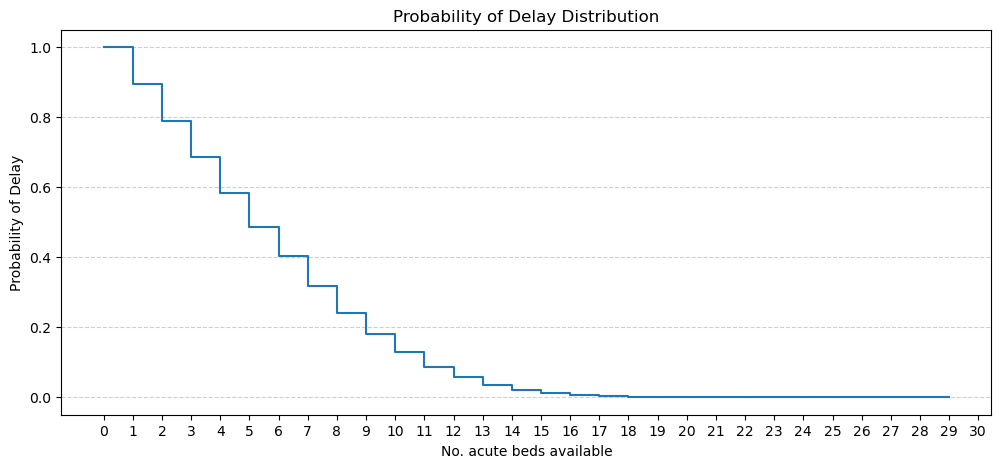

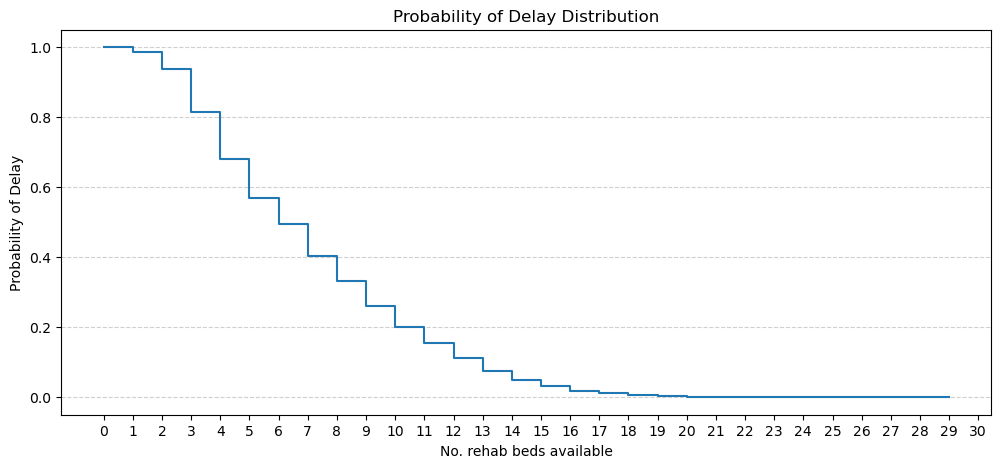

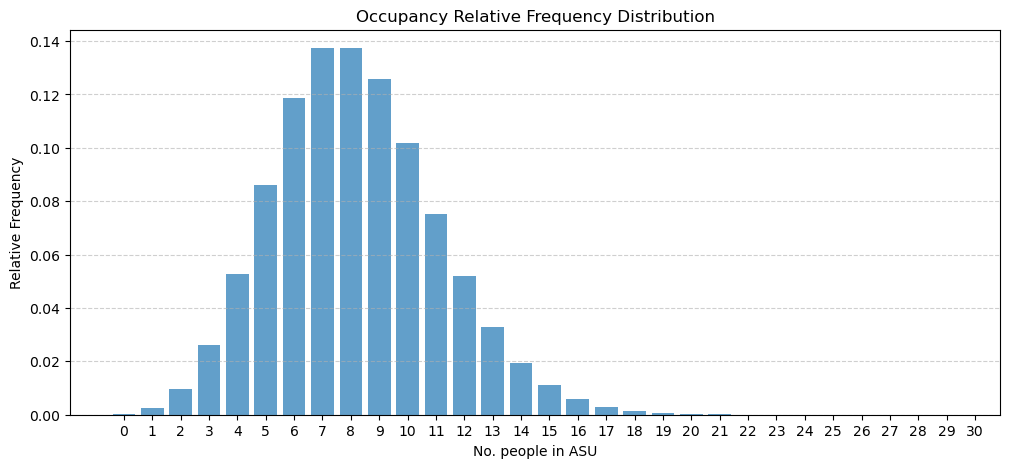

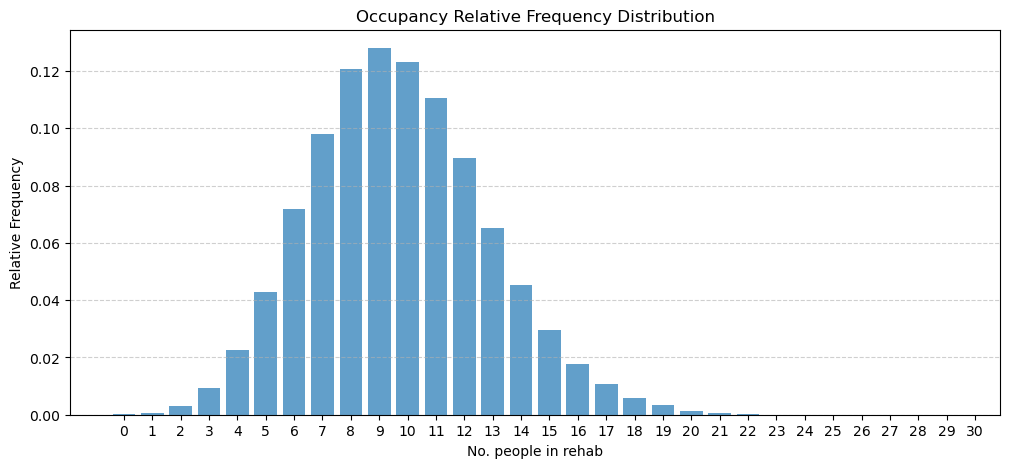

In [21]:
# Create an instance of Experiment  (default params, default warm-up and rcp).
experiment = Experiment()

# run multiple replications
rep_results = multiple_replications(experiment, 100)

# combine results and take the mean 
pd_asu, pd_rehab = combine_pdelay_results(rep_results)
rel_asu, rel_rehab = combine_occup_results(rep_results)
mean_pd_asu, mean_pd_rehab = mean_results(pd_asu), mean_results(pd_rehab)
mean_rel_asu, mean_rel_rehab = mean_results(rel_asu), mean_results(rel_rehab)

# prob delay plots 
prob_delay_plot(mean_pd_asu, np.arange(0, 30))
prob_delay_plot(mean_pd_rehab, np.arange(0, 30), "No. rehab beds available")

# prob occupancy plots
occupancy_plot(mean_rel_asu, np.arange(0, 30))
occupancy_plot(mean_rel_rehab, np.arange(0, 30), "No. people in rehab")

## tabular results
# acute
df_acute = summary_table(mean_pd_asu, 9, 14, "acute")
df_rehab = summary_table(mean_pd_rehab, 10, 16, "rehab")


In [22]:
df_acute

,p(delay),1 in every n patients delayed
No. acute beds,,
9,0.18,5
10,0.13,7
11,0.09,11
12,0.06,17
13,0.03,29
14,0.02,50


In [23]:
df_rehab

,p(delay),1 in every n patients delayed
No. rehab beds,,
10,0.20,4
11,0.15,6
12,0.11,9
13,0.07,13
14,0.05,20
15,0.03,32
16,0.02,54


## Testing <a class="anchor" id="testing_code"></a>
* **Results processing 1**: code correctly calculates relative and cumulative frequencies
    * Expected result: for [1, 1, 1, 1, 2, 2, 2, 3, 3, 4] relative = [4/10, 3/10, 2/10, 1/10] and cum = [4/10, 7/10, 9/10, 1.0]
    * Actual result (PASS): for [1, 1, 1, 1, 2, 2, 2, 3, 3, 4] relative = [4/10, 3/10, 2/10, 1/10] and cum = [4/10, 7/10, 9/10, 1.0]
* **Results processing 2**: test that prob delay is calculated correctly.
    * Expected result: The probability of delay is [1.0, 0.3/0.7, 0.2/0.9, 0.1/1.0]
    * Actual result (PASS): The probability of delay is [1.0, 0.3/0.7, 0.2/0.9, 0.1/1.0]
* **Results collection test 1**: Test the result collection process for ASU collects ward occupancy every day
    * Expected result: The number of observations taken is 1 less the number of days the model is run.
    * Actual result (PASS):  The number of observations taken is 1 less the number of days the model is run.
* **Results collection test 2**: Test ASU ward occupancy data collected is in a sensible range.
    * Expected result: The type collected is int. The values are in the range 0 to 50 with sensible moments.
    * Actual result (PASS):  The type collected is int. The values are in the range 0 to 50 with sensible moments.
* **Results collection test 3**: Test the result collection process for REHAB collects unit occupancy every day
    * Expected result: The number of observations taken is 1 less the number of days the model is run.
    * Actual result (PASS):  The number of observations taken is 1 less the number of days the model is run.
* **Results collection test 4**: Test REHAB unit occupancy data collected is in a sensible range.
    * Expected result: The type collected is int. The values are in the range 0 to (10-15) with sensible moments.
    * Actual result (PASS):  The type collected is int. The values are 0 to (10-15) with sensible moments.
* **Results collection test 5**: **SYSTEM TEST**: Test the result collection process for ASU+REHAB collects ward occupancy every day
    * Expected result: The number of observations taken is 1 less the number of days the model is run.
    * Actual result (PASS):  The number of observations taken is 1 less the number of days the model is run.
* **Single run test**: **SYSTEM TEST**: Test that the `single_run` function returns a dictionary of results
  * Expected Result: len(run_results) == 6 and type(run_results) == dict
  * Actual Result (PASS): len(run_results) == 6 and type(run_results) == dict
* **Warm-up Period Test**: Test warm-up works correctly for ASU+REHAB ward occupancy. Audit interval = 1 and Warm-up > 0
    * Expected result: The length of the occupancy data collection arrays is equal to the results collection period.
    * Actual result (PASS): The length of the occupancy data collection arrays is equal to the results collection period.
* **Suppress simulated trace**: Test that setting experiment.trace = False suppresses ASU output by default.
    * Expected result: The ASU model runs with no simulated log output
    * Actual result (PASS): The ASU model runs with no simulated log output
* **Suppress simulated trace 2**: Test that setting experiment.trace = False suppresses REHAB output by default.
    * Expected result: The REHAB model runs with no simulated log output
    * Actual result (PASS): The REHAB model runs with no simulated log output
* **Testing lognormal function**: Test that lognomal function correctly calculates the moments of the underlying normal dist.
    * Expected result: The LLM generated function and `sim-tools.distributions.Lognormal` perform the same conversion.
    * Actual results (PASS):  The functions generate the same values.
* **Extreme value test 1**: TIA, Complex Neuro, Other, have their inter-arrival time is set to $M$ a very large number
    * Expected result: The only type of patient to arrive to the model is "Stroke"
    * Actual result (PASS): The only type of patient to arrive to the model is "Stroke"
* **Extreme value test 2**: All patient types have have their inter-arrival time is set to $M$ a very large number
    * Expected result: No patients arrive to the model.
    * Actual result (PASS): No patients arrive to the model.
* **Different run length**: The run length of the model is set to 10 days.
    * Expected result: The model should runs no longer than 10 simulated time periods
    * Actual result (PASS): The model runs no longer than 10 simulated time periods
* **Extreme value test 3**: All patient types have have their mean length of stay time set to $M$ a very large number
    * Expected result: No patients depart the model (only arrivals seen in log)
    * Actual Results (PASS): No patients depart the model.
* **Extreme value test 4**: All patient types apart from stroke->rehab have have their mean length of stay time set to $M$ a very large number
    * Expected result: Only stroke patients depart the model (seen in log)
    * Actual Results (PASS): Only stroke patient depart the model.
* **Extreme value test 5**: In rehab, Complex Neuro, and Other, have their inter-arrival time is set to $M$ a very large number
    * Expected result: The only type of patient to arrive to the rehab model is "Stroke"
    * Actual result (PASS): The only type of patient to arrive to the rehab model is "Stroke"
* **Extreme value test 6**: In the rehab model, all patient types have have their inter-arrival time is set to $M$ a very large number
    * Expected result: No patients arrive to the model.
    * Actual result (PASS): No patients arrive to the model.
* **Extreme value test 7**: In the rehab model, all patient types have their length of stay means set to $M$ a very larger number.
    * Expected result: Patients arrive to the model as normal, but do not depart.
    * Actual result (PASS): Patients arrive to the model as normal, but do not depart.

### Results processing 1

Test that the code correctly calculates the relative and cumulative frequencies of a python list of integer values.

(PASS)

In [24]:
def result_processing_test_1(values, rel_expected, cum_expected):
    '''
    Test the `calculate_occupancy_frequencies` function works
    as expected.

    Expected result: relative frequencies and cumulative freqs
    are the same as expected values.

    Params:
    ------
    values: list
        list of values to test

    rel_expected: list
        list of floats - expected relative freqs

    cum_expected: list
        list of floats - expected cumulative freqs

    Returns:
    -------
    bool: does the model pass the test.
    '''
    rel, cum, unique = calculate_occupancy_frequencies(values)
    # use all close to allow for minor floating point differences.
    return (set(rel) == set(rel_expected)) and  np.allclose(np.array(cum_expected), cum)

In [25]:
result_processing_test_1(values=[1, 1, 1, 1, 2, 2, 2, 3, 3, 4],
                         rel_expected=[0.4, 0.3, 0.2, 0.1],
                         cum_expected=[0.4, 0.7, 0.9, 1.0])

True

### Results Processing test 2

Test that the calculation of the probability of delay is correct.

(PASS)

In [26]:
def result_processing_test_2(relative, cum, p_delay_expected):
    '''
    Test the probability of delay is calculated correctly.
    
    Params:
    ------
    relative: list
        list of floats - relative freqs

    cum: list
        list of floats - cumulative freqs

    Returns:
    -------
    bool: does the function pass the test.
    '''
    p_delay = calculate_prob_delay(relative, cum)
    # use all close to allow for minor floating point differences.
    return np.allclose(np.array(p_delay_expected), p_delay)

In [27]:
relative = [0.4, 0.3, 0.2, 0.1],
cum = [0.4, 0.7, 0.9, 1.0]
expected = [1.0, 0.3/0.7, 0.2/0.9, 0.1/1.0]
result = result_processing_test_2(relative, cum, expected)
result

True

### Results collection test 1

Test the optional results collection process works correctly.  The process should collect acute stroke occupancy every day

(PASS)

In [28]:
def results_collection_test1(audit_interval=1):
    '''
    Test the model collects acute stroke occupancy every day

    Expected result: len(experiment.occupancy) == env.now - 1

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    bool: does the model pass the test.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arr~ival rates
    default_experiment_params = Experiment()

    # modified iteration 19. 
    # add RU, but do not run the model
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())

    # optional results collection
    # Start the audit_acute_occupancy generator function to record ASU occupancy at intervals
    # MODIFIED iter 21
    env.process(audit_acute_occupancy(env, 1, audit_interval, acu_experiment, default_experiment_params))
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 21
    env.run(until=default_experiment_params.results_collection_period)

    print(f'{len(default_experiment_params.asu_occupancy)=}')
    print(f'{env.now=}')
    return len(default_experiment_params.asu_occupancy) == (env.now - 1)

In [29]:
results_collection_test1()

len(default_experiment_params.asu_occupancy)=1824
env.now=1825


True

### Result collection test 2

(PASS)

In [30]:
def results_collection_test2(audit_interval=1):
    '''
    Test ASU ward occupancy data collected is in a sensible range.
    
    Expected result: The type collected is int. The values are in 
    the range in the range 0 to 50 with sensible moments.

    prints out:
    min
    max
    mean
    deciles

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    None
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arr~ival rates
    default_experiment_params = Experiment()

    # modified iteration 19. 
    # add RU, but do not run the model
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())

    # optional results collection
    # Start the audit_acute_occupancy generator function to record ASU occupancy at intervals
    # MODIFIED iter 21
    env.process(audit_acute_occupancy(env, 1, audit_interval, acu_experiment, default_experiment_params))
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 21
    env.run(until=default_experiment_params.results_collection_period)

    print(f'{min(default_experiment_params.asu_occupancy)=}')
    print(f'{max(default_experiment_params.asu_occupancy)=}')
    print(f'{statistics.fmean(default_experiment_params.asu_occupancy)=}')
    print([round(q, 1) for q in statistics.quantiles(default_experiment_params.asu_occupancy, n=10)])

In [31]:
results_collection_test2()

min(default_experiment_params.asu_occupancy)=1
max(default_experiment_params.asu_occupancy)=18
statistics.fmean(default_experiment_params.asu_occupancy)=8.105263157894736
[5.0, 6.0, 6.0, 7.0, 8.0, 9.0, 9.0, 10.0, 12.0]


### Results collection test 3

Test the optional results collection process works correctly for rehab.  The process should collect rehab unit occupancy every day.

(PASS)


In [32]:
def results_collection_test3(audit_interval=1):
    '''
    Test the model collects rehab occupancy every day

    Expected result: len(experiment.rehab_occupancy) == env.now - 1

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    bool: does the model pass the test.
    '''
    # Create the simulation environment
    env = simpy.Environment()

    # create experiment
    default_experiment = Experiment()
    
    rehab_unit = RehabilitationUnit(env, default_experiment)

    # Initialise the patient generators as simpy processes
    env.process(rehab_unit.stroke_patient_generator())
    env.process(rehab_unit.neuro_patient_generator())
    env.process(rehab_unit.other_patient_generator())
    
    # Initialise the audit of rehab occupancy as a simpy process with an interval of 1 day
    # MODIFIED iter 12
    env.process(audit_rehab_occupancy(env, 1, audit_interval, rehab_unit, default_experiment))
    
    # Run the model for the default run length in the experiment
    # MODIFIED iter 12
    env.run(until=default_experiment.results_collection_period)
    print(f'{len(default_experiment.rehab_occupancy)=}')
    print(f'{env.now=}')
    return len(default_experiment.rehab_occupancy) == (env.now - 1)

In [33]:
results_collection_test3()

len(default_experiment.rehab_occupancy)=1824
env.now=1825


True

## Results Collection Test 4

(PASS)

In [34]:
def results_collection_test4(audit_interval=1):
    '''
    Test REHAB ward occupancy data collected is in a sensible range.
    
    Expected result: The type collected is int. The values are in 
    the range in the range 1 to [10-15] with sensible moments.

    Note this is when the Rehab unit is used independently
    with external arrivals only i.e. no transfers from ASU.

    prints out:
    min
    max
    mean
    deciles

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    None
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # create experiment
    default_experiment = Experiment()
    
    rehab_unit = RehabilitationUnit(env, default_experiment)

    # Initialise the patient generators as simpy processes
    env.process(rehab_unit.stroke_patient_generator())
    env.process(rehab_unit.neuro_patient_generator())
    env.process(rehab_unit.other_patient_generator())
    
    # Initialise the audit of rehab occupancy as a simpy process with an interval of 1 day
    # MODIFIED iter 12
    env.process(audit_rehab_occupancy(env, 1, audit_interval, rehab_unit, default_experiment))
    
    # Run the model for the default run length in the experiment
    # MODIFIED iter 12
    env.run(until=default_experiment.results_collection_period)
    
    print(f'{min(default_experiment.rehab_occupancy)=}')
    print(f'{max(default_experiment.rehab_occupancy)=}')
    print(f'{statistics.fmean(default_experiment.rehab_occupancy)=}')
    print([round(q, 1) for q in statistics.quantiles(default_experiment.rehab_occupancy, n=10)])

In [35]:
results_collection_test4()

min(default_experiment.rehab_occupancy)=0
max(default_experiment.rehab_occupancy)=9
statistics.fmean(default_experiment.rehab_occupancy)=2.598135964912281
[1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 3.0, 4.0, 5.0]


### Results Collection Test 5 (SYSTEM TEST)

Test that when the models are linked that the occupancy is audited correctly.

In [36]:
def results_collection_test5(audit_interval=1):
    '''
    Test REHAB ward occupancy data collected is in a sensible range
    when it is connected to the ASU model.
    
    Expected result: The type collected is int. The values are in 
    the range in the range 1 to [10-15] with sensible moments.

    Expected result: 
        len(experiment.asu_occupancy) == env.now - 1 AND
        len(experiment.rehab_occupancy) == env.now - 1

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    bool: does the model pass the test.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # a default experiment
    default_experiment_params = Experiment()

    # create models
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the ASU patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())

    # Initialize the pREHAB atient generators as simpy processes
    env.process(rehab_unit.stroke_patient_generator())
    env.process(rehab_unit.neuro_patient_generator())
    env.process(rehab_unit.other_patient_generator())  

    # optional results collection
    # Start the audit_acute_occupancy generator function to record ASU occupancy at intervals
    # MODIFIED iter 12
    env.process(audit_acute_occupancy(env, 1, audit_interval, acu_experiment, default_experiment_params))

    # Initialize the audit of rehab occupancy as a simpy process with an interval of 1 day
    # MODIFIED iter 12
    env.process(audit_rehab_occupancy(env, 1, audit_interval, rehab_unit, default_experiment_params))
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 12
    env.run(until=default_experiment_params.results_collection_period)

    # print info for debug
    print(f'{len(default_experiment_params.asu_occupancy)=}')
    print(f'{len(default_experiment_params.rehab_occupancy)=}')
    print(f'{env.now=}')

    # test
    return len(default_experiment_params.asu_occupancy) == (env.now - 1) and \
        len(default_experiment_params.rehab_occupancy) == (env.now - 1)

In [37]:
results_collection_test5()

len(default_experiment_params.asu_occupancy)=1824
len(default_experiment_params.rehab_occupancy)=1824
env.now=1825


True

### Results Collection Test 6 (SYSTEM TEST)


In [38]:
def results_collection_test6(audit_interval=1):
    '''
    Test the model collects acute stroke occupancy every day

    Expected result: The type collected is int. The values are in 
    the range in the range 1 to ~25 with sensible moments.

    Note this is when the Rehab unit is linked to the ASU.
    I.e. transfers from ASU + external arrivals

    prints out:
    min
    max
    mean
    deciles

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    bool: does the model pass the test.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # a default experiment
    default_experiment_params = Experiment()

    # create models
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the ASU patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())

    # Initialize the pREHAB atient generators as simpy processes
    env.process(rehab_unit.stroke_patient_generator())
    env.process(rehab_unit.neuro_patient_generator())
    env.process(rehab_unit.other_patient_generator())  

    # optional results collection
    # Start the audit_acute_occupancy generator function to record ASU occupancy at intervals
    # MODIFIED iter 12
    env.process(audit_acute_occupancy(env, 1, audit_interval, acu_experiment, default_experiment_params))

    # Initialize the audit of rehab occupancy as a simpy process with an interval of 1 day
    # MODIFIED iter 12
    env.process(audit_rehab_occupancy(env, 1, audit_interval, rehab_unit, default_experiment_params))
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 12
    env.run(until=default_experiment_params.results_collection_period * 10)

    # test
    print(f'{min(default_experiment_params.rehab_occupancy)=}')
    print(f'{max(default_experiment_params.rehab_occupancy)=}')
    print(f'{statistics.fmean(default_experiment_params.rehab_occupancy)=}')
    print([round(q, 1) for q in statistics.quantiles(default_experiment_params.rehab_occupancy, n=10)])

In [39]:
results_collection_test6()

min(default_experiment_params.rehab_occupancy)=0
max(default_experiment_params.rehab_occupancy)=21
statistics.fmean(default_experiment_params.rehab_occupancy)=9.754781083895008
[6.0, 7.0, 8.0, 9.0, 10.0, 10.0, 11.0, 12.0, 14.0]


### Warm-up Test

(PASS)

In [40]:
def warm_up_test(warm_up, audit_interval=1):
    '''
    Test warm-up works correctly for ASU+REHAB ward occupancy

    Expected result: 
        len(experiment.asu_occupancy) == experiment.results_collection_period 
        AND len(experiment.rehab_occupancy) == experiment.results_collection_period 

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    bool: does the model pass the test.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # a default experiment
    default_experiment_params = Experiment(warm_up=warm_up)

    # create models
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the ASU patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())

    # Initialize the pREHAB atient generators as simpy processes
    env.process(rehab_unit.stroke_patient_generator())
    env.process(rehab_unit.neuro_patient_generator())
    env.process(rehab_unit.other_patient_generator())  

    # optional results collection
    # Start the audit_acute_occupancy generator function to record ASU occupancy at intervals
    env.process(audit_acute_occupancy(env, warm_up, audit_interval, acu_experiment, default_experiment_params))

    # Initialize the audit of rehab occupancy as a simpy process with an interval of 1 day
    env.process(audit_rehab_occupancy(env, warm_up, audit_interval, rehab_unit, default_experiment_params))
    
    # Run the simulation until the specified run length in the Experiment parameters
    env.run(until=default_experiment_params.warm_up + default_experiment_params.results_collection_period)

    # print info for debug
    print(f'{len(default_experiment_params.asu_occupancy)=}')
    print(f'{len(default_experiment_params.rehab_occupancy)=}')
    print(f'{env.now=}')
    print(f'{default_experiment_params.results_collection_period=}')
    print(f'{default_experiment_params.warm_up + default_experiment_params.results_collection_period=}')

    # test
    return len(default_experiment_params.asu_occupancy) == (default_experiment_params.results_collection_period) and \
        len(default_experiment_params.rehab_occupancy) == (default_experiment_params.results_collection_period) 

In [41]:
warm_up_test(warm_up=365)

len(default_experiment_params.asu_occupancy)=1825
len(default_experiment_params.rehab_occupancy)=1825
env.now=2190
default_experiment_params.results_collection_period=1825
default_experiment_params.warm_up + default_experiment_params.results_collection_period=2190


True

### Single run test (SYSTEM TEST)

In [42]:
def single_run_test():
    '''
    Test the the single_run function returns a dictionary of 
    results.

    The results dictionary contains the following keys:

    'relative_freq_asu'
    'prob_delay_asu'
    'unique_vals_asu'
    'relative_freq_rehab'
    'prob_delay_rehab'
    'unique_vals_rehab'

    Expected result: 
        len(run_results) == 6 and type(run_results) == dict

    Returns:
    -------
    bool: does the model pass the test.
    '''

    # a default experiment
    default_experiment_params = Experiment()

    # run the model
    run_results = single_run(default_experiment_params)

    print(f"{run_results['relative_freq_asu']=}")
    
    # test
    return len(run_results) == 6 and type(run_results) == dict

In [43]:
single_run_test()

run_results['relative_freq_asu']=array([0.00164384, 0.00547945, 0.0169863 , 0.04273973, 0.07287671,
       0.12547945, 0.13205479, 0.14191781, 0.12547945, 0.09753425,
       0.08493151, 0.05753425, 0.03287671, 0.02849315, 0.01424658,
       0.00876712, 0.00547945, 0.00383562, 0.00109589, 0.00054795])


True

## Test suppress trace 1

(PASS)

In [44]:
def test_suppress_log(trace):
    '''
    Test that setting experiment.trace 
    False suppresses output.

    Expected result: patient_count > 0

    Params:
    ------
    trace: bool
        is trace outputted or not?

    Returns:
    -------
    int: number of patient arrivals.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arr~ival rates
    default_experiment_params = Experiment(
        trace=trace,
    )

    # modified iteration 19. 
    # add RU, but do not run the model
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 12
    env.run(until=default_experiment_params.results_collection_period)

    return acu_experiment.patient_count

In [45]:
test_suppress_log(trace=False)

2709

### Test suppress trace 2

In [46]:
def test_suppress_log_rehab(trace):
    '''
    Test that setting experiment.trace to
    False suppresses output in the rehab model

    Expected result: patient_count > 0

    Params:
    ------
    trace: bool
        is trace outputted or not?

    Returns:
    -------
    int: number of patient arrivals.
    '''
    # Create the simulation environment
    env = simpy.Environment()

    # create experiment
    default_experiment_params = Experiment(

        trace=trace,   
    )

    # this will be need to be modified in subsequent iterations
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    
    # Start the patient generators for each type of patient in the instance
    env.process(rehab_unit.stroke_patient_generator())
    env.process(rehab_unit.neuro_patient_generator())
    env.process(rehab_unit.other_patient_generator())
        
    # Run the simulation until the specified run length
    env.run(until=100)

    # print out stats collected
    print(f'{rehab_unit.patient_count=}')
    print(f'{rehab_unit.stroke_count=}')
    print(f'{rehab_unit.neuro_count=}')
    print(f'{rehab_unit.other_count=}')
    print(f'{rehab_unit.occupancy=}')
    return rehab_unit.patient_count

In [47]:
test_suppress_log_rehab(False)

rehab_unit.patient_count=10
rehab_unit.stroke_count=2
rehab_unit.neuro_count=3
rehab_unit.other_count=5
rehab_unit.occupancy=1


10

### Lognormal test

Test that lognomal function correctly calculates the moments of the underlying normal dist.

**Result: PASS**

In [48]:
def test_lognormal_moments(mean, std):
    '''
    Test that lognomal function correctly calculates 
    the moments of the underlying normal dist.

    Params:
    ------
    mean: float
        mean of the lognormal distribution

    std: float
        st dev of the lognormal distribution

    Returns:
    -------
    bool
    '''
   
    # Lognormal class from sim-tools.
    expected_moments = Lognormal(mean, std)
    print(expected_moments.mu, expected_moments.sigma)
    
    ## llm code
    llm_mu, llm_sigma = normal_moments_from_lognormal(mean, std)
    print(llm_mu, llm_sigma)
    
    return (llm_mu, llm_sigma) == (expected_moments.mu, expected_moments.sigma)

In [49]:
test_lognormal_moments(128.79, 267.51)

4.022977459259615 1.2924439729790718
4.022977459259615 1.2924439729790718


True

### Extreme value test 1

The model uses hard coded parameters.  The most simple way to modify the code for this test was to change hard coded parameters for $M$

**Result: PASS**

In [50]:
M = 10_000_000

In [51]:
def ev_test_1(large_number):
    '''
    TIA, Complex Neuro, Other, have their inter-arrival 
    time is set to $M$ a very large number
    
    Expected result: The only type of patient to arrive to the model 
    is "Stroke". This is seen in the event log

    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    int: the number of patients that arrived to the model.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arrival rates
    default_experiment_params = Experiment(
        tia_mean=large_number,
        neuro_mean=large_number,
        other_mean=large_number,
        trace=True,
    )

    # modified iteration 19. 
    # add RU, but do not run the model
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 12
    env.run(until=default_experiment_params.results_collection_period)

    return acu_experiment.patient_count

In [52]:
ev_test_1(M)

Stroke patient 1 arrived at 1.3126605617008806 days and will go to Other
Stroke patient 2 arrived at 1.6474477444256734 days and will go to ESD
Stroke patient 3 arrived at 3.2616219935474446 days and will go to Other
Stroke patient 3 finished treatment at 3.677986378635074 days
Stroke patient 3 finished treatment at 4.176557060412231 days
Stroke patient 4 arrived at 5.768978590323895 days and will go to Rehab
Stroke patient 5 arrived at 8.960486204369486 days and will go to Other
Stroke patient 6 arrived at 9.115837842788176 days and will go to Other
Stroke patient 7 arrived at 10.610338487368018 days and will go to ESD
Stroke patient 8 arrived at 10.676197633574768 days and will go to Rehab
Stroke patient 9 arrived at 10.914208253463805 days and will go to Other
Stroke patient 10 arrived at 11.156596096741382 days and will go to Other
Stroke patient 10 finished treatment at 11.210374158431875 days
Stroke patient 10 finished treatment at 12.023110716287192 days
Stroke patient 10 finish

1513

### Extreme value test 2

* An experiment is setup so that all patient types have a mean inter-arrival rate of $M$

**Result: PASS**

In [53]:
def ev_test_2(large_number):
    '''
    All patient types have have their inter-arrival time is 
    set to $M$ a very large number
    
    Expected result: No patients arrive to the model.
    
    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    int: the number of patients that arrived to the model.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arrival rates
    default_experiment_params = Experiment(
        stroke_mean=large_number,
        tia_mean=large_number,
        neuro_mean=large_number,
        other_mean=large_number,
        trace=False,
    )

    # modified iteration 19. 
    # add RU, but do not run the model
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 12
    env.run(until=default_experiment_params.results_collection_period)

    return acu_experiment.patient_count

In [54]:
ev_test_2(M)

0

### Different run length test

The model has again been modified to use the original code and parameters generated by the LLM.

In [55]:
TEN_DAYS = 10

In [56]:
def test_run_length(run_length):
    '''
    Test that the run length of the model can be modified.
    
    Expected result: The model should runs no longer than the new run length.

    Params:
    ------
    run_length: float
        Run length of the model in days.

    Returns:
    -------
    float
        Simulation end time.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arrival rates
    # MODIFIED iter 21
    default_experiment_params = Experiment(
        results_collection_period=run_length,
        trace=False,
    )

    # modified iteration 19. 
    # add RU, but do not run the model
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 21
    env.run(until=default_experiment_params.results_collection_period)

    return env.now

In [57]:
test_run_length(TEN_DAYS)

10

### Extreme value test 3

* An experiment is setup so that all patient types have a mean length of stay on the ASU of $M$

**Result: PASS**

In [58]:
def ev_test_3(large_number):
    '''
    All patient types have have their mean length 
    of stay time set to $M$ a very large number
    
    Expected result: No patients depart the model 
    The number of arrivals = the occupancy of the model.

    Params:
    -------
    large_number: int
        M a very large number 
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arrival rates
    default_experiment_params = Experiment(
        rehab_mean=M,  # stroke->rehab
        esd_mean=M,    # stroke-> ESD
        other_dest_mean=M, # stroke->other
        tia_dest_mean=M,   # TIA patients
        neuro_dest_mean=M, # complex neuro patients
        other_dest_mean_2=M, # other (med outlier) patients
        trace=False,
    )

    # modified iteration 19. 
    # add RU, but do not run the model
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 21
    env.run(until=default_experiment_params.results_collection_period)

    print(f'{acu_experiment.patient_count=}')
    print(f'{acu_experiment.occupancy=}')
    
    return acu_experiment.patient_count == acu_experiment.occupancy 

In [59]:
result = ev_test_3(M)

acu_experiment.patient_count=2816
acu_experiment.occupancy=2816


In [60]:
result

True

### Extreme value test 4

* An experiment is setup so that all patient types other than stroke->rehab have a mean length of stay on the ASU of $M$

**Result: PASS**

In [61]:
def ev_test_4(large_number):
    '''
    All patient types apart from stroke-rehab patients
    have have their mean length 
    of stay time set to $M$ a very large number
    
    Expected result: Only stroke patients depart the
    model.
    (assed by viewing  log and patient_count > occupancy)

    Params:
    -------
    large_number: int
        M a very large number 
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arrival rates
    default_experiment_params = Experiment(
        rehab_mean=7.4,  # stroke->rehab
        esd_mean=M,    # stroke-> ESD
        other_dest_mean=M, # stroke->other
        tia_dest_mean=M,   # TIA patients
        neuro_dest_mean=M, # complex neuro patients
        other_dest_mean_2=M, # other (med outlier) patients
        trace=False,
    )

    # modified iteration 19. 
    # add RU, but do not run the model
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 21
    env.run(until=default_experiment_params.results_collection_period)

    print(f'{acu_experiment.patient_count=}')
    print(f'{acu_experiment.occupancy=}')
    
    return acu_experiment.patient_count > acu_experiment.occupancy

In [62]:
results = ev_test_4(M)

acu_experiment.patient_count=2764
acu_experiment.occupancy=2423


In [63]:
results

True

### Extreme value test 5

Only stroke arrivals to the Rehab unit

(PASS)

In [64]:
def ev_test_5(large_number):
    '''
    Complex Neuro, Other, have their rehab inter-arrival 
    time is set to $M$ a very large number
    
    Expected result: The only type of patient to arrive to the rehab model 
    is "Stroke". This is verified by the patient counts variables in the model.

    Notes:
    ------
    This test will need to be modified when the hardcoded parameters
    are migrated to the Experiment class. 

    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    bool: rehab_unit.stroke_count == rehab_unit.patient_count
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # set Rehab arrival rates
    default_experiment_params = Experiment(
        rehab_neuro_iat = large_number,
        rehab_other_iat = large_number,
    )
    
    # this will be need to be modified in subsequent iterations
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
        
    # Start the patient generators for each type of patient in the RehabilitationUnit instance
    env.process(rehab_unit.stroke_patient_generator())
    env.process(rehab_unit.neuro_patient_generator())
    env.process(rehab_unit.other_patient_generator())
        
    # Run the simulation until the specified run length
    env.run(until=1825)

    # print out stats collected
    print(f'{rehab_unit.patient_count=}')
    print(f'{rehab_unit.stroke_count=}')
    print(f'{rehab_unit.neuro_count=}')
    print(f'{rehab_unit.other_count=}')
    
    return rehab_unit.stroke_count == rehab_unit.patient_count

In [65]:
ev_test_5(M)

rehab_unit.patient_count=73
rehab_unit.stroke_count=73
rehab_unit.neuro_count=0
rehab_unit.other_count=0


True

### Extreme Value test 6

No arrivals to the rehab unit.

(PASS)

In [66]:
def ev_test_6(large_number):
    '''
    All patient types have their REHAN inter-arrival 
    time is set to $M$ a very large number
    
    Expected result: No patients arrive to the model
    This is verified by the patient count variables in the model.

    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    bool:rehab_unit.patient_count == 0
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # set Rehab arrival rates
    default_experiment_params = Experiment(
        rehab_stroke_iat = large_number,
        rehab_neuro_iat = large_number,
        rehab_other_iat = large_number,
    )
    
    # this will be need to be modified in subsequent iterations
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    
    # Start the patient generators for each type of patient in the RehabilitationUnit instance
    env.process(rehab_unit.stroke_patient_generator())
    env.process(rehab_unit.neuro_patient_generator())
    env.process(rehab_unit.other_patient_generator())
        
    # Run the simulation until the specified run length
    env.run(until=1825)

    # print out stats collected
    print(f'{rehab_unit.patient_count=}')
    print(f'{rehab_unit.stroke_count=}')
    print(f'{rehab_unit.neuro_count=}')
    print(f'{rehab_unit.other_count=}')
    print(f'{rehab_unit.occupancy=}')
    
    return rehab_unit.patient_count == 0

In [67]:
ev_test_6(M)

rehab_unit.patient_count=0
rehab_unit.stroke_count=0
rehab_unit.neuro_count=0
rehab_unit.other_count=0
rehab_unit.occupancy=0


True

### Extreme value test 7

In the rehab model, all patient types have their length of stay means set to $M$ a very larger number.

(PASS)

In [68]:
def ev_test_7(large_number):
    '''
    All patient types have have their mean length 
    of stay time in REHAB set to $M$ a very large number
    
    Expected result: No patients depart the rehab model 
    The occupancy of the model is equal to the no. patient arrivals
    
    Notes:
    -----
    This test will also need to be modified when TIA treatment is added
    and tested when working in connection with the ASU.

    Params:
    -------
    large_number: int
        M a very large number 
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arrival rates
    default_experiment_params = Experiment(
        rehab_stroke_esd_mean=large_number, # stroke->ESD
        rehab_stroke_other_mean=large_number, # stroke->other
        rehab_neuro_mean=large_number, # complex neuro
        rehab_other_mean=large_number, # other patients.
        trace=False,   
    )

    # this will be need to be modified in subsequent iterations
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    
    # Start the patient generators for each type of patient in the instance
    env.process(rehab_unit.stroke_patient_generator())
    env.process(rehab_unit.neuro_patient_generator())
    env.process(rehab_unit.other_patient_generator())
        
    # Run the simulation until the specified run length
    env.run(until=100)

    # print out stats collected
    print(f'{rehab_unit.patient_count=}')
    print(f'{rehab_unit.stroke_count=}')
    print(f'{rehab_unit.neuro_count=}')
    print(f'{rehab_unit.other_count=}')
    print(f'{rehab_unit.occupancy=}')
    
    return rehab_unit.patient_count == rehab_unit.occupancy

In [69]:
ev_test_7(M)

rehab_unit.patient_count=13
rehab_unit.stroke_count=3
rehab_unit.neuro_count=4
rehab_unit.other_count=6
rehab_unit.occupancy=13


True

### Extreme value test 8 (SYSTEM TEST)

Set all inter-arrival times - asu and rehab to $M$. Where $M$ is a very large number.

In [70]:
def ev_test_8(large_number):
    '''
    All patient types have their AUS and REHAB inter-arrival 
    time is set to $M$ a very large number
    
    Expected result: No patients arrive to the model
    This is verified by the patient count variables in the model.

    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    bool:rehab_unit.patient_count == 0 and asu.patient_count == 0
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # set Rehab arrival rates
    default_experiment_params = Experiment(
        stroke_mean=large_number,
        tia_mean=large_number,
        neuro_mean=large_number,
        other_mean=large_number,
        rehab_stroke_iat = large_number,
        rehab_neuro_iat = large_number,
        rehab_other_iat = large_number,
    )
    
    # create models
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the ASU patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())

    # Initialize the pREHAB atient generators as simpy processes
    env.process(rehab_unit.stroke_patient_generator())
    env.process(rehab_unit.neuro_patient_generator())
    env.process(rehab_unit.other_patient_generator())  

    # no optional data collection needed in this test
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 21
    env.run(until=default_experiment_params.results_collection_period)

    # print out stats collected
    print(f'{acu_experiment.patient_count=}')
    print(f'{rehab_unit.patient_count=}')
    print(f'{rehab_unit.stroke_count=}')
    print(f'{rehab_unit.neuro_count=}')
    print(f'{rehab_unit.other_count=}')
    print(f'{rehab_unit.occupancy=}')
    
    return rehab_unit.patient_count == 0 and acu_experiment.patient_count== 0

In [71]:
ev_test_8(M)

acu_experiment.patient_count=0
rehab_unit.patient_count=0
rehab_unit.stroke_count=0
rehab_unit.neuro_count=0
rehab_unit.other_count=0
rehab_unit.occupancy=0


True